In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression # Para baseline de classificação
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)

In [2]:
df_vendas=pd.read_excel("Vendas.xlsx")

In [10]:
df_vendas.columns

Index(['DataEmissao', 'NFe', 'cdProduto', 'Produto', 'Grupo Produto',
       'Linha Produto', 'cdVendedor', 'Vendedor', 'Supervisor', 'Gerente',
       'Equipe Vendas', 'QtdItens', 'ValorUnitario'],
      dtype='object')

In [3]:
df_vendas=df_vendas.sample(frac=.5)
df_vendas.shape

(287031, 13)

In [11]:
df_vendas['Equipe Vendas'].value_counts()

,count
Equipe Vendas,
Varejo,107198
Online,82280
Atacado,51737
Distribuidoras,45816


In [5]:
# Copiar para preservar o original
df = df_vendas.copy()

# --- Limpeza e Pré-processamento ---
df = df.drop(columns=[ 'NFe', 'Produto', 'Vendedor', 'Supervisor', 'Gerente'])
df = df.dropna(subset=['Equipe Vendas', 'Linha Produto']) # Crucial para os targets

# Converter DataEmissao e extrair features temporais
df['DataEmissao'] = pd.to_datetime(df['DataEmissao'])
df['Ano'] = df['DataEmissao'].dt.year
df['Mes'] = df['DataEmissao'].dt.month
df['DiaSemana'] = df['DataEmissao'].dt.dayofweek
df['DiaAno'] = df['DataEmissao'].dt.dayofyear
df['Trimestre'] = df['DataEmissao'].dt.quarter

In [6]:
# --- Modelo 1: Previsão de Canal de Venda (`Equipe Vendas`) ---
print("--- Modelo 1: Previsão de Canal de Venda ---")
df_canal = df.copy()
df_canal = df_canal.dropna() # Remover quaisquer NaNs restantes

# Target: Equipe Vendas
target_canal = 'Equipe Vendas'
y_canal = df_canal[target_canal]

# Features
# cdProduto e cdVendedor são códigos, podem ser tratados como categóricos.
# QtdItens e ValorUnitario podem influenciar o canal.
features_canal_num = ['QtdItens', 'ValorUnitario', 'Ano', 'Mes', 'DiaSemana', 'DiaAno', 'Trimestre']
features_canal_cat = ['cdProduto', 'Grupo Produto', 'Linha Produto', 'cdVendedor']

# Garantir que as colunas categóricas sejam string
for col in features_canal_cat:
    df_canal[col] = df_canal[col].astype(str)

X_canal = df_canal[features_canal_num + features_canal_cat]

--- Modelo 1: Previsão de Canal de Venda ---


In [7]:

# Label Encoding para o target (Equipe Vendas) pois alguns modelos podem preferir
le_canal = LabelEncoder()
y_canal_encoded = le_canal.fit_transform(y_canal)
print(f"Classes do Canal de Venda: {le_canal.classes_}")


# Preprocessor para features do modelo de canal
preprocessor_canal = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_canal_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_canal_cat)
    ],
    remainder='passthrough'
)

# Pipeline com RandomForestClassifier
pipeline_rfc_canal = Pipeline(steps=[
    ('preprocessor', preprocessor_canal),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1))
])

# Dividir dados
X_train_canal, X_test_canal, y_train_canal, y_test_canal = train_test_split(
    X_canal, y_canal_encoded, test_size=0.25, random_state=42, stratify=y_canal_encoded
)

Classes do Canal de Venda: ['Atacado' 'Distribuidoras' 'Online' 'Varejo']


In [8]:
# Treinar
pipeline_rfc_canal.fit(X_train_canal, y_train_canal)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['QtdItens', 'ValorUnitario',
                                                   'Ano', 'Mes', 'DiaSemana',
                                                   'DiaAno', 'Trimestre']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['cdProduto', 'Grupo Produto',
                                                   'Linha Produto',
                                                   'cdVendedor'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [9]:

# Prever e Avaliar
y_pred_canal_encoded = pipeline_rfc_canal.predict(X_test_canal)
y_pred_canal = le_canal.inverse_transform(y_pred_canal_encoded) # Voltar para os nomes originais
y_test_canal_orig = le_canal.inverse_transform(y_test_canal)


print(f"\nAcurácia (RandomForestClassifier para Canal): {accuracy_score(y_test_canal_orig, y_pred_canal):.3f}")
print("Relatório de Classificação (RandomForestClassifier para Canal):")
print(classification_report(y_test_canal_orig, y_pred_canal, zero_division=0))


Acurácia (RandomForestClassifier para Canal): 0.635
Relatório de Classificação (RandomForestClassifier para Canal):
                precision    recall  f1-score   support

       Atacado       0.33      0.37      0.35     12934
Distribuidoras       1.00      1.00      1.00     11454
        Online       0.60      0.54      0.57     20570
        Varejo       0.67      0.68      0.67     26800

      accuracy                           0.63     71758
     macro avg       0.65      0.65      0.65     71758
  weighted avg       0.64      0.63      0.64     71758



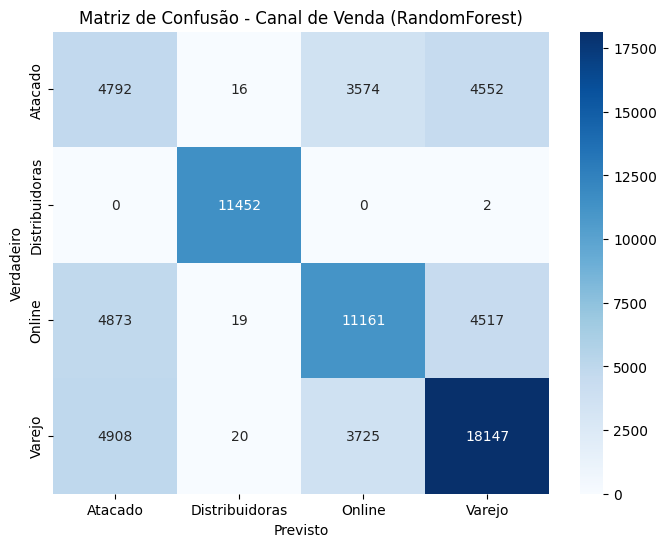

In [12]:
# Matriz de Confusão
cm_canal = confusion_matrix(y_test_canal_orig, y_pred_canal, labels=le_canal.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_canal, annot=True, fmt='d', cmap='Blues', xticklabels=le_canal.classes_, yticklabels=le_canal.classes_)
plt.title('Matriz de Confusão - Canal de Venda (RandomForest)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [19]:
# --- Modelo 2: Previsão de Demanda por Linha de Produto ---
print("\n--- Modelo 2: Previsão de Demanda por Linha de Produto (Mensal) ---")
df_demanda = df.copy()

# Agregação Mensal
# Primeiro, garante que df_demanda_agg contenha as colunas 'MesAno', 'Linha Produto', 'QtdTotalVendida'
df_demanda_agg = df_demanda.groupby([pd.Grouper(key='DataEmissao', freq='M'), 'Linha Produto'])['QtdItens'].sum().reset_index()
df_demanda_agg.rename(columns={'DataEmissao': 'MesAno', 'QtdItens': 'QtdTotalVendida'}, inplace=True)
df_demanda_agg = df_demanda_agg.sort_values(['Linha Produto', 'MesAno']) # Importante para lags corretos por grupo

# Criar features de lag e data para cada Linha de Produto
def create_features_for_demand(df_group, lags=6):
    df_temp = df_group.copy()

    # Lags da QtdTotalVendida
    for lag in range(1, lags + 1):
        df_temp[f'lag_{lag}'] = df_temp['QtdTotalVendida'].shift(lag)

    # Features de Data (a partir da coluna 'MesAno' que já é datetime)
    df_temp['Mes'] = df_temp['MesAno'].dt.month
    df_temp['Ano'] = df_temp['MesAno'].dt.year
    df_temp['Trimestre'] = df_temp['MesAno'].dt.quarter

    return df_temp.dropna() # Remove linhas com NaNs criados pelos lags iniciais

# Aplicar a função a cada grupo de 'Linha Produto'
df_demanda_features = df_demanda_agg.groupby('Linha Produto', group_keys=False).apply(
    lambda x: create_features_for_demand(x, lags=6)
).reset_index(drop=True)

if df_demanda_features.empty:
    print("Não foi possível gerar features de demanda (poucos dados ou lags insuficientes).")
else:
    print("\nExemplo de Features para Demanda (df_demanda_features):")
    display(df_demanda_features.head())


--- Modelo 2: Previsão de Demanda por Linha de Produto (Mensal) ---


<ipython-input-19-e4a2b29d6c06>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_demanda_agg = df_demanda.groupby([pd.Grouper(key='DataEmissao', freq='M'), 'Linha Produto'])['QtdItens'].sum().reset_index()



Exemplo de Features para Demanda (df_demanda_features):


<ipython-input-19-e4a2b29d6c06>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_demanda_features = df_demanda_agg.groupby('Linha Produto', group_keys=False).apply(


,MesAno,Linha Produto,QtdTotalVendida,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Mes,Ano,Trimestre
0,2017-07-31,Alimentos,128260,96836.0,97626.0,85110.0,46179.0,24955.0,5079.0,7,2017,3
1,2017-08-31,Alimentos,108411,128260.0,96836.0,97626.0,85110.0,46179.0,24955.0,8,2017,3
2,2017-09-30,Alimentos,115104,108411.0,128260.0,96836.0,97626.0,85110.0,46179.0,9,2017,3
3,2017-10-31,Alimentos,127505,115104.0,108411.0,128260.0,96836.0,97626.0,85110.0,10,2017,4
4,2017-11-30,Alimentos,113063,127505.0,115104.0,108411.0,128260.0,96836.0,97626.0,11,2017,4



--- Tentativa de Melhoria no Modelo de Demanda ---

Avaliação com TimeSeriesSplit (target log-transformado):
Fold 1
  Fold MAE: 6780.43, Fold R2: -0.11
Fold 2
  Fold MAE: 28383.53, Fold R2: -1.13
Fold 3
  Fold MAE: 2094.32, Fold R2: 0.71
Fold 4
  Fold MAE: 2667.42, Fold R2: 0.92
Fold 5
  Fold MAE: 2664.60, Fold R2: 0.90

Overall MAE (com TimeSeriesSplit, escala original): 8518.06
Overall R2 (com TimeSeriesSplit, escala original): -0.10


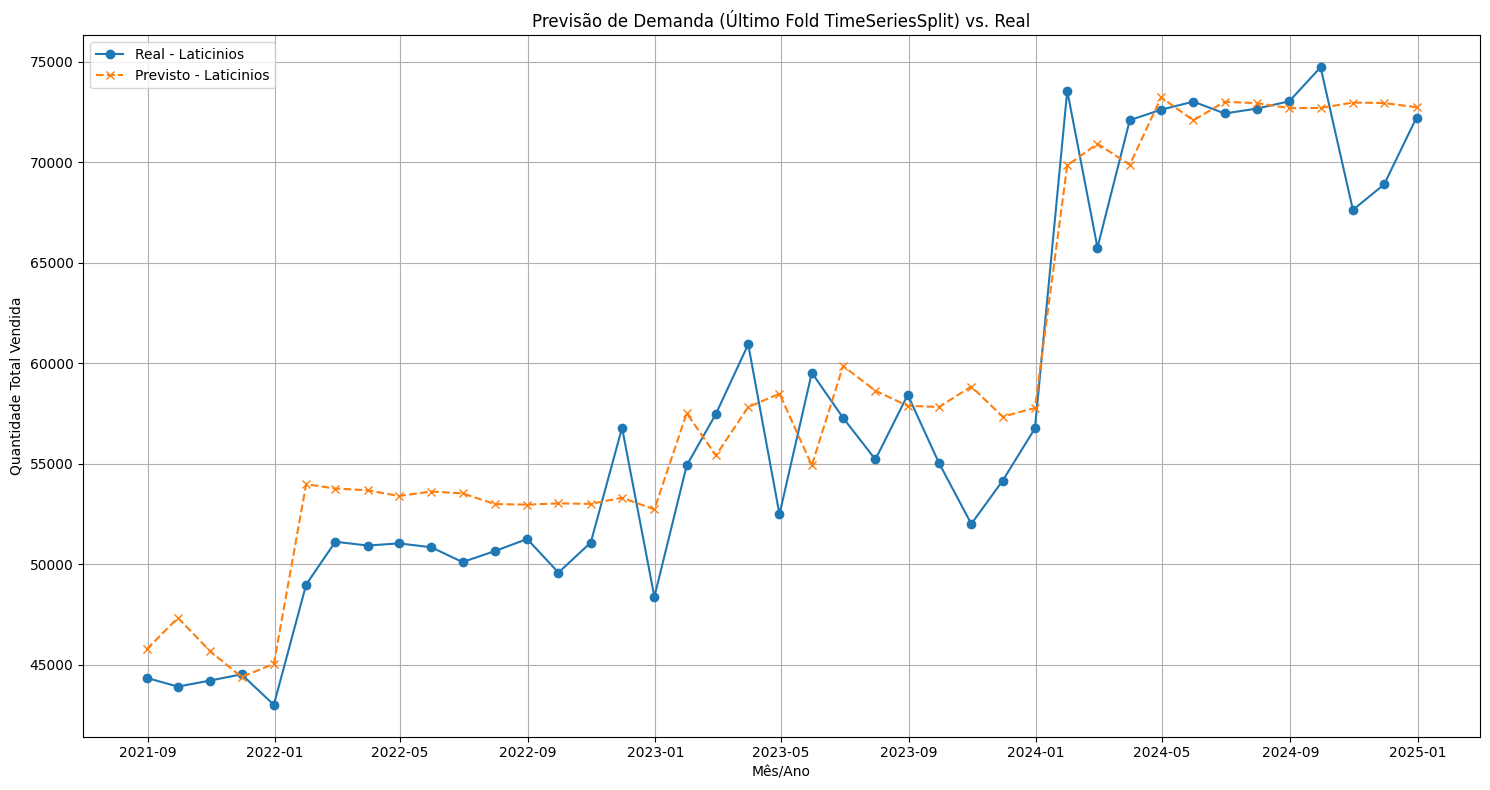

In [20]:


if not df_demanda_features.empty:
    print("\n--- Tentativa de Melhoria no Modelo de Demanda ---")

    target_demanda = 'QtdTotalVendida'
    features_demanda_num = [col for col in df_demanda_features.columns if 'lag_' in col or col in ['Mes', 'Ano', 'Trimestre']]
    features_demanda_cat = ['Linha Produto']

    X_demanda = df_demanda_features.copy()

    # Aplicar transformação logarítmica no target
    y_demanda_log = np.log1p(df_demanda_features[target_demanda])

    preprocessor_demanda = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_demanda_num),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_demanda_cat)
        ],
        remainder='passthrough'
    )

    pipeline_rfr_demanda_log = Pipeline(steps=[
        ('preprocessor', preprocessor_demanda),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    # TimeSeriesSplit - requer que X seja ordenado
    # Nota: TimeSeriesSplit funciona melhor com uma única série.
    # Para múltiplas séries, precisamos ter cuidado. A forma mais simples é aplicá-lo aos dados ordenados globalmente.

    df_demanda_features_sorted = df_demanda_features.sort_values(['Linha Produto', 'MesAno'])

    # Usar um índice numérico simples para TimeSeriesSplit
    X_demanda_for_split = df_demanda_features_sorted[features_demanda_num + features_demanda_cat]
    y_demanda_log_for_split = np.log1p(df_demanda_features_sorted[target_demanda])

    # Armazenar informações para plotagem posterior
    metadata_for_plot = df_demanda_features_sorted[['MesAno', 'Linha Produto', target_demanda]].copy()

    tscv = TimeSeriesSplit(n_splits=5)

    all_preds = []
    all_true = []
    all_metadata = []

    print("\nAvaliação com TimeSeriesSplit (target log-transformado):")
    for fold, (train_index, test_index) in enumerate(tscv.split(X_demanda_for_split)):
        print(f"Fold {fold+1}")
        X_train, X_test = X_demanda_for_split.iloc[train_index], X_demanda_for_split.iloc[test_index]
        y_train, y_test_log = y_demanda_log_for_split.iloc[train_index], y_demanda_log_for_split.iloc[test_index]

        current_test_metadata = metadata_for_plot.iloc[test_index]

        if X_train.empty or X_test.empty:
            print(f"Skipping fold {fold+1} due to empty train/test set.")
            continue

        pipeline_rfr_demanda_log.fit(X_train, y_train)
        y_pred_log = pipeline_rfr_demanda_log.predict(X_test)

        # Transformar de volta para a escala original
        y_pred_original_scale = np.expm1(y_pred_log)
        y_test_original_scale = np.expm1(y_test_log)


        y_pred_original_scale = np.maximum(0, y_pred_original_scale)

        all_preds.extend(y_pred_original_scale)
        all_true.extend(y_test_original_scale) # ou current_test_metadata[target_demanda].values
        all_metadata.append(current_test_metadata)

        fold_mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
        fold_r2 = r2_score(y_test_original_scale, y_pred_original_scale)
        print(f"  Fold MAE: {fold_mae:.2f}, Fold R2: {fold_r2:.2f}")

    if all_preds:
        overall_mae = mean_absolute_error(all_true, all_preds)
        overall_r2 = r2_score(all_true, all_preds)
        print(f"\nOverall MAE (com TimeSeriesSplit, escala original): {overall_mae:.2f}")
        print(f"Overall R2 (com TimeSeriesSplit, escala original): {overall_r2:.2f}")

        # Plotar para o último fold como exemplo
        if all_metadata:
            last_fold_metadata = all_metadata[-1]
            last_fold_true = last_fold_metadata[target_demanda] # Reais da última fold
            # As predições correspondentes ao último fold
            num_preds_last_fold = len(last_fold_true)
            last_fold_preds = all_preds[-num_preds_last_fold:]

            plot_df_last_fold = pd.DataFrame({
                'MesAno': last_fold_metadata['MesAno'],
                'Linha Produto': last_fold_metadata['Linha Produto'],
                'Real': last_fold_true,
                'Previsto': last_fold_preds
            })

            plt.figure(figsize=(15, 8))
            unique_linhas_last_fold = plot_df_last_fold['Linha Produto'].unique()
            for i, linha in enumerate(unique_linhas_last_fold[:3]): # Plotar algumas linhas
                subset = plot_df_last_fold[plot_df_last_fold['Linha Produto'] == linha]
                if not subset.empty:
                    plt.plot(subset['MesAno'], subset['Real'], label=f'Real - {linha}', marker='o', linestyle='-')
                    plt.plot(subset['MesAno'], subset['Previsto'], label=f'Previsto - {linha}', marker='x', linestyle='--')

            plt.title('Previsão de Demanda (Último Fold TimeSeriesSplit) vs. Real')
            plt.xlabel('Mês/Ano')
            plt.ylabel('Quantidade Total Vendida')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

else:
    print("Não foi possível gerar features de demanda (poucos dados ou lags insuficientes) para a tentativa de melhoria.")